# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

## Aggregating diverse distance functions

We want to combine different distance metrics operating on subsets of the data to one distance value. As a toy model, assume we want to combine a Laplace and a Normal distance.

In [ ]:
# install if not done yet
!pip install pyabc --quiet

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import pyabc

p_true = {'p0': 0, 'p1': 0}


def model(p):
    return {
        's0': p['p0'] + 0.1 * np.random.normal(),
        's1': p['p1'] + 0.1 * np.random.normal(),
    }


observation = {'s0': 0, 's1': 0}


def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])


def distance1(x, x_0):
    return (x['s1'] - x_0['s1']) ** 2


# prior
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2), p1=pyabc.RV("uniform", -1, 2)
)

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-05-19 15:19:12>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.93828347e-01.
ABC INFO: Accepted: 100 / 227 = 4.4053e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 5.47513600e-01.
ABC INFO: Accepted: 100 / 227 = 4.4053e-01, ESS: 9.3165e+01.
ABC INFO: t: 2, eps: 3.48865157e-01.
ABC INFO: Accepted: 100 / 192 = 5.2083e-01, ESS: 8.7158e+01.
ABC INFO: t: 3, eps: 2.17783825e-01.
ABC INFO: Accepted: 100 / 249 = 4.0161e-01, ESS: 8.8381e+01.
ABC INFO: t: 4, eps: 1.47444558e-01.
ABC INFO: Accepted: 100 / 340 = 2.9412e-01, ESS: 9.2480e+01.
ABC INFO: t: 5, eps: 8.91141994e-02.
ABC INFO: Accepted: 100 / 394 = 2.5381e-01, ESS: 7.4999e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:03.119590, end_time=2021-05-19 15:19:15>


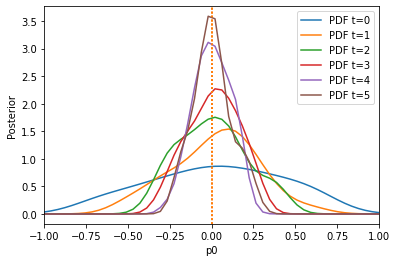

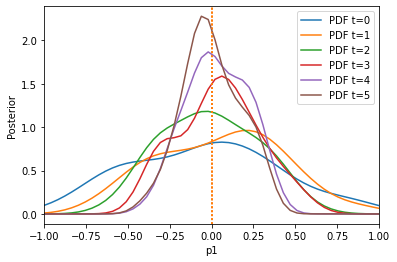

In [2]:
distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting


def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=-1,
            xmax=1,
            x='p0',
            ax=ax,
            label=f"PDF t={t}",
            refval=p_true,
        )
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=-1,
            xmax=1,
            x='p1',
            ax=ax,
            label=f"PDF t={t}",
            refval=p_true,
        )
    ax.legend()


plot_history(history1)

## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-05-19 15:19:32>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.59935137e+03.
ABC INFO: Accepted: 100 / 215 = 4.6512e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.09029894e+03.
ABC INFO: Accepted: 100 / 421 = 2.3753e-01, ESS: 9.3548e+01.
ABC INFO: t: 2, eps: 2.14142711e+02.
ABC INFO: Accepted: 100 / 784 = 1.2755e-01, ESS: 9.1347e+01.
ABC INFO: t: 3, eps: 4.48406680e+01.
ABC INFO: Accepted: 100 / 1955 = 5.1151e-02, ESS: 7.7921e+01.
ABC INFO: t: 4, eps: 1.34184695e+01.
ABC INFO: Accepted: 100 / 3585 = 2.7894e-02, ESS: 7.8617e+01.
ABC INFO: t: 5, eps: 4.69471462e+00.
ABC INFO: Accepted: 100 / 6668 = 1.4997e-02, ESS: 9.5092e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=2, duration=0:00:10.112188, end_time=2021-05-19 15:19:42>


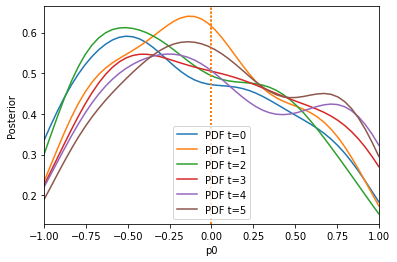

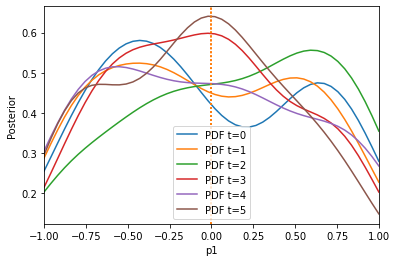

In [3]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import pyabc

p_true = {'p0': 0, 'p1': 0}


def model(p):
    return {
        's0': p['p0'] + 0.1 * np.random.normal(),
        's1': p['p1'] + 100 * np.random.normal(),
    }


observation = {'s0': 0, 's1': 0}


def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])


def distance1(x, x_0):
    return (x['s1'] - x_0['s1']) ** 2


# prior
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2), p1=pyabc.RV("uniform", -1, 2)
)

distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting


def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=-1,
            xmax=1,
            x='p0',
            ax=ax,
            label=f"PDF t={t}",
            refval=p_true,
        )
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=-1,
            xmax=1,
            x='p1',
            ax=ax,
            label=f"PDF t={t}",
            refval=p_true,
        )
    ax.legend()


plot_history(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `pyabc.distance.AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2021-05-19 15:19:54>
ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 5.56804028e-01.
ABC INFO: Accepted: 100 / 215 = 4.6512e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.16722119e-01.
ABC INFO: Accepted: 100 / 190 = 5.2632e-01, ESS: 9.2354e+01.
ABC INFO: t: 2, eps: 2.20958442e-01.
ABC INFO: Accepted: 100 / 346 = 2.8902e-01, ESS: 9.6911e+01.
ABC INFO: t: 3, eps: 1.61422674e-01.
ABC INFO: Accepted: 100 / 408 = 2.4510e-01, ESS: 8.1748e+01.
ABC INFO: t: 4, eps: 1.16683118e-01.
ABC INFO: Accepted: 100 / 587 = 1.7036e-01, ESS: 7.4133e+01.
ABC INFO: t: 5, eps: 6.81859941e-02.
ABC INFO: Accepted: 100 / 1256 = 7.9618e-02, ESS: 8.0627e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=3, duration=0:00:04.460621, end_time=2021-05-19 15:19:59>


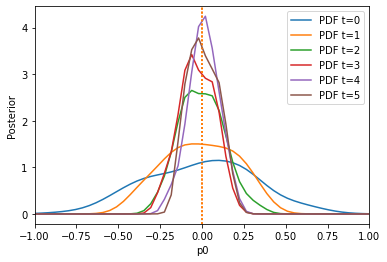

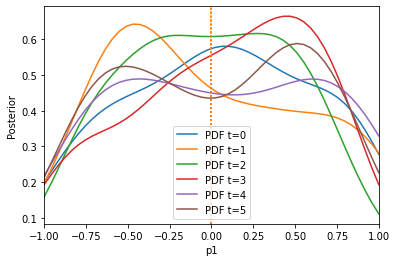

In [4]:
# prior
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2), p1=pyabc.RV("uniform", -1, 2)
)

distance = pyabc.AdaptiveAggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=6)

plot_history(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2021-05-19 15:20:40>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 5.66625277e-01.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.59666990e-01.
ABC INFO: Accepted: 100 / 219 = 4.5662e-01, ESS: 9.1798e+01.
ABC INFO: t: 2, eps: 2.23159544e-01.
ABC INFO: Accepted: 100 / 300 = 3.3333e-01, ESS: 9.4351e+01.
ABC INFO: t: 3, eps: 1.44789110e-01.
ABC INFO: Accepted: 100 / 336 = 2.9762e-01, ESS: 8.3898e+01.
ABC INFO: t: 4, eps: 9.83630433e-02.
ABC INFO: Accepted: 100 / 597 = 1.6750e-01, ESS: 8.1514e+01.
ABC INFO: t: 5, eps: 5.39954272e-02.
ABC INFO: Accepted: 100 / 1284 = 7.7882e-02, ESS: 6.7990e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:03.763636, end_time=2021-05-19 15:20:44>


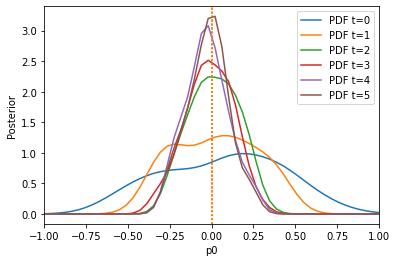

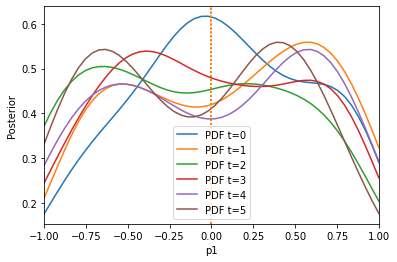

In [5]:
# prior
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2), p1=pyabc.RV("uniform", -1, 2)
)

distance = pyabc.AdaptiveAggregatedDistance(
    [distance0, distance1], adaptive=False
)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=6)

plot_history(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time. Note that one can also specify other scale functions, by passing ``AdaptiveAggregatedDistance(distances, scale_function)``, e.g. ``pyabc.distance.mean[/median/span]``.

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

<AxesSubplot:title={'center':'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

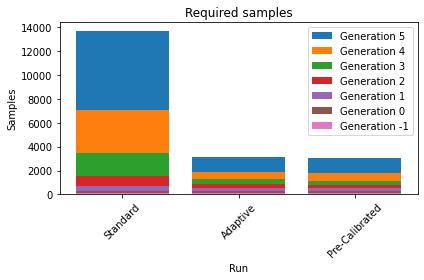

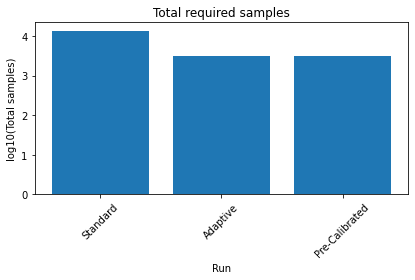

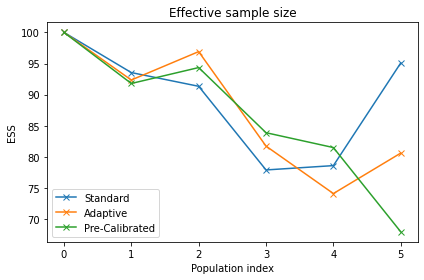

In [6]:
histories = [history1, history2, history3]
labels = ["Standard", "Adaptive", "Pre-Calibrated"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(
    histories, labels, yscale='log10', rotation=45
)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)